In [340]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import glob 
import matplotlib.image as img
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import numpy as np
import math
import csv
from PIL import Image
import time
import sklearn.metrics


In [341]:
# set device 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("device type:", device)
print("current device:", torch.cuda.get_device_name(torch.cuda.current_device()))

dtype = torch.float

device type: cuda
current device: NVIDIA GeForce GTX 1060 6GB


In [342]:
# map labels to ids (alphabetically)

classIdByLabel = {}
classNames : list = sorted(os.listdir(os.path.join("..", "dane", "test")))
i = 0
for className in classNames:
    classIdByLabel[className] = i
    i += 1

# print("classIdByLabel:\n" + "\n".join([(str(classIdByLabel[c]) + "\t" + c) for c in classIdByLabel]))

In [343]:
# create dataset class

class BirdDataset(Dataset):
    def __init__(self, dataset_type: str, classNames, transform=None):
        self.transform = transform
        self.image_paths = [path for sublist in [glob.glob(os.path.join("..", "dane", dataset_type, label, "*.jpg"), recursive=False) for label in classNames] for path in sublist] 
        self.labels = torch.tensor([classIdByLabel[path.split("/")[3]] for path in self.image_paths])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):

        image = Image.open(self.image_paths[i])

        if self.transform:
            image = self.transform(image)
        
        return image, self.labels[i]


In [344]:
# example data for testing if everything works

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
    ])
example_batch_size = 32
example_number_of_classes = 63
exampleTrainDataset = BirdDataset("train", classNames[:example_number_of_classes], transform)

print(len(exampleTrainDataset))
checkClasses = set([path.split("/")[3] for path in exampleTrainDataset.image_paths])
# print(checkClasses)
# print("\n".join(exampleTrainDataset.image_paths))

exampleTrainLoader = DataLoader(exampleTrainDataset, batch_size=example_batch_size, shuffle=True, num_workers=4, drop_last=True)

7490


0 torch.Size([3, 224, 224]) 32
1 torch.Size([3, 224, 224]) 32
2 torch.Size([3, 224, 224]) 32
3 torch.Size([3, 224, 224]) 32
4 torch.Size([3, 224, 224]) 32


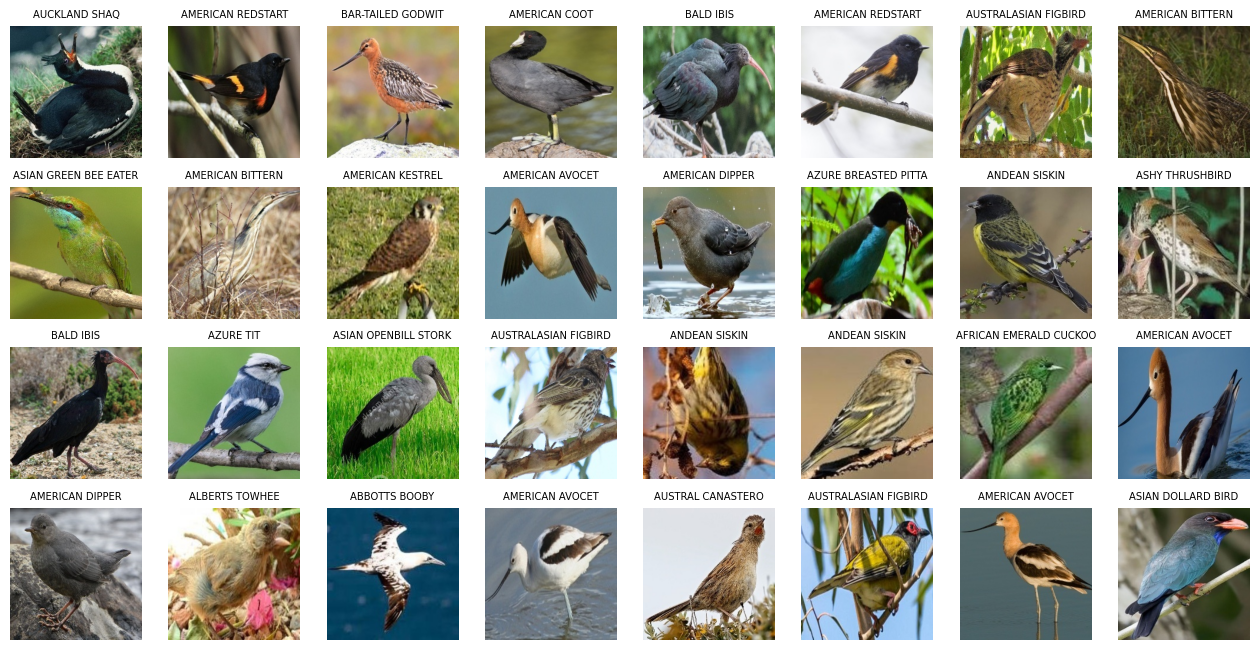

In [345]:
# show single batch of example data

for i_batch, sample_batch in enumerate(exampleTrainLoader):
    images_batch, labels_batch = sample_batch
    print(i_batch, images_batch[0].size(), len(labels_batch))

    # observe 4th batch and stop.
    if i_batch == 4:
        plt.figure(figsize=(16,8))
        plt.rc('font', size=6)

        for index in range(example_batch_size):
            plt.subplot(4,8,index+1)
            plt.imshow(images_batch[index].squeeze().permute(1,2,0))
            plt.title(list(classIdByLabel.keys())[list(classIdByLabel.values()).index(labels_batch[index])])
            plt.axis('off')

        
        plt.ioff()
        plt.show()
        break

In [350]:
# tune a pretrained model

number_of_classes = 100

weights = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1
model = torchvision.models.efficientnet_b0(weights=weights)
preprocess = weights.transforms()
in_features = model.classifier[1].in_features
gap = math.floor((in_features - number_of_classes) / 3)
print(in_features, in_features - gap, in_features - gap*2, in_features - gap*3)

dropout = 0.2
model.classifier = nn.Sequential(
    # nn.Dropout(dropout),
    nn.Linear(in_features, 900),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(900, 650),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(650, number_of_classes)
)

for name, param in model.named_parameters():
    if name.split(".")[0] == "classifier":
        param.requires_grad = True
    else: 
        param.requires_grad = False

# print(model)

1280 887 494 101


In [351]:
# create datasets 

batch_size = 32

trainDataset = BirdDataset("train", classNames[:number_of_classes], preprocess)
trainLoader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=False)

validDataset = BirdDataset("valid", classNames[:number_of_classes], preprocess)
validLoader = DataLoader(validDataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=False)

# testDataset = BirdDataset("test", preprocess)
# testLoader = DataLoader(testDataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=False)

In [352]:
# calculate class weights

classWeights = [0 for _ in range(525)]

# total = len(trainDataset.image_paths)

for className in classNames[:number_of_classes]:
    classWeights[classIdByLabel[className]] = 100.0 /len(os.listdir(os.path.join("..", "dane", "train", className)))
    # print(classWeights[classIdByLabel[className]], className)
print("min:", min(classWeights), "max:", max(classWeights))


min: 0 max: 1.0204081632653061


In [353]:
# train

criterion = nn.CrossEntropyLoss(weight = torch.tensor(classWeights[:number_of_classes]).to(device))
optimizer = torch.optim.SGD(model.parameters(), lr=3e-3, momentum=0.9) # , weight_decay=1e-5
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
step = 500
epochs = 50

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model.to(device)

for epoch in range(epochs):

    correct = 0
    running_loss = 0.0
    valid_running_loss = 0.0
    all_input_labels = []
    all_predicted_labels = []

    timestart = time.time()
    epochtime = time.time()

    # train
    model.train()
    for i, data in enumerate(trainLoader, 0):        
        # get the inputs
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() * images.size(0)
        
        if i % step == step-1:
            print("\r", f'[epoch: {epoch + 1}, {100*batch_size*(i + 1)/len(trainDataset):.3f}%, {math.floor(time.time() - timestart):3d}s] loss: {running_loss / len(trainDataset):.3f}', end="")
            timestart = time.time()

    # validate 
    model.eval()
    for i, data in enumerate(validLoader, 0):
        # get the inputs
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        loss = criterion(outputs, labels)

        # print statistics
        valid_running_loss += loss.item() * images.size(0)
        correct += torch.sum(predicted == labels.data)
        all_predicted_labels.append(predicted.cpu())
        all_input_labels.append(labels.cpu())


    scheduler.step()
    
    epoch_loss = valid_running_loss / len(validDataset)
    accuracy = correct.double() / len(validDataset)
    all_input_labels = np.concatenate(all_input_labels)
    all_predicted_labels = np.concatenate(all_predicted_labels)
    f1_score = sklearn.metrics.f1_score(all_input_labels, all_predicted_labels, average='weighted', sample_weight=[classWeights[label_id] for label_id in all_input_labels])
    print("\r" + f'epoch: {epoch + 1}/{epochs}, time: {math.floor(time.time() - epochtime)}s, accuracy: {accuracy:.3f}, loss: {epoch_loss:.3f}, weighted f1 score: {f1_score:.3f}')

print('done')

epoch: 1/50, time: 39s, accuracy: 0.234, loss: 4.499, weighted f1 score: 0.200
epoch: 2/50, time: 38s, accuracy: 0.318, loss: 3.795, weighted f1 score: 0.280
epoch: 3/50, time: 38s, accuracy: 0.577, loss: 2.098, weighted f1 score: 0.550
epoch: 4/50, time: 38s, accuracy: 0.693, loss: 1.280, weighted f1 score: 0.688
epoch: 5/50, time: 38s, accuracy: 0.755, loss: 0.959, weighted f1 score: 0.745
epoch: 6/50, time: 38s, accuracy: 0.784, loss: 0.819, weighted f1 score: 0.777
epoch: 7/50, time: 38s, accuracy: 0.818, loss: 0.687, weighted f1 score: 0.818
epoch: 8/50, time: 38s, accuracy: 0.832, loss: 0.654, weighted f1 score: 0.831
epoch: 9/50, time: 38s, accuracy: 0.839, loss: 0.621, weighted f1 score: 0.839
epoch: 10/50, time: 39s, accuracy: 0.830, loss: 0.642, weighted f1 score: 0.830
epoch: 11/50, time: 38s, accuracy: 0.842, loss: 0.595, weighted f1 score: 0.841
epoch: 12/50, time: 38s, accuracy: 0.843, loss: 0.603, weighted f1 score: 0.843
epoch: 13/50, time: 39s, accuracy: 0.844, loss: 0

KeyboardInterrupt: 